In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
from jaxtyping import Key, Array
import optax
import einops
from sklearn import datasets
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from models import ResidualNetwork

In [2]:
class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, mlp_kwargs, *, key):
        self.net = eqx.nn.MLP(**mlp_kwargs, key=key)

    def __call__(self, x_t, t):
        return self.encode(x_t, t)
    
    def variational_posterior_log_prob(self, key, x_0, x_t, t):
        # This is the score of log(q(z|x_t, t))
        mu_t, sigma_t = self.encode(x_t, t)
        # Encode input data
        mu_0, sigma_0 = self.encode(x_0, 0.) # z ~ q(z|x_0, 0), as per diagram
        z = jr.multivariate_normal(key, mu_0, jnp.diag(sigma_0))
        return jax.scipy.stats.multivariate_normal.logpdf(z, mu_t, jnp.diag(sigma_t))

    def encode(self, x_t, t):
        t = jnp.atleast_1d(t)
        x_t_t = jnp.concatenate([x_t.flatten(), t])
        mu_t, log_sigma_t = jnp.split(self.net(x_t_t), 2)
        return mu_t, jnp.exp(log_sigma_t)

    def score(self, key, x, x_t, t): 
        # Score of variational distribution q(z|x_t, t) defined by encoder
        return jax.jacfwd(self.variational_posterior_log_prob, argnums=2)(key, x, x_t, t)

    def prior_log_prob_z(self, z):
        return jax.scipy.stats.norm.logpdf(z).sum() # Unit Gaussian 

In [3]:
def kl_loss(mu, sigma):
    # Assuming sigma is diagonal elements of covariance (NOTE: sigma exp'd)
    return mu.T @ mu + sigma.sum() - mu.size - jnp.prod(sigma)


def int_beta(t):
    return t


def weight(t): 
    return 1. - jnp.exp(-int_beta(t))  


def dataloader(x, batch_size, *, key):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        key, subkey = jr.split(key, 2)
        perm = jr.permutation(subkey, indices)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield x[batch_perm]
            start = end
            end = start + batch_size


def single_loss_fn(encoder, score_network, weight, int_beta, x, t, key):
    # Encoder training objective given trained diffusion model
    key_score, key_noise = jr.split(key)
    t = jnp.atleast_1d(t)

    # Diffusion loss calculations
    mean = x * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1. - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key_noise, x.shape)
    x_t = mean + std * noise

    mu_t, sigma_t = encoder.encode(x_t, t)

    _score = score_network(x_t, t) 
    _score_encoder = encoder.score(key_score, x, x_t, t) # d_(x_t)[log q(z|x_t, t)]
    score = _score + _score_encoder # Bayes rule for scores

    # Score of encoder model plus score of diffusion model
    return weight(t) * jnp.square(score + noise / std) - kl_loss(mu_t, sigma_t)


def batch_loss_fn(encoder, score_network, weight, int_beta, x, t1, key):
    batch_size = x.shape[0]
    key_t, key_L = jr.split(key)
    keys = jr.split(key_L, batch_size)

    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(key_t, (batch_size,), minval=0., maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)

    loss_fn = partial(single_loss_fn, encoder, score_network, weight, int_beta)
    return jnp.mean(jax.vmap(loss_fn)(x, t, keys))


@eqx.filter_jit
def make_step(encoder, score_network, weight, int_beta, x, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(encoder, score_network, weight, int_beta, x, t1, key)
    updates, opt_state = opt_update(grads, opt_state, encoder)
    encoder = eqx.apply_updates(encoder, updates)
    key = jr.split(key, 1)[0]
    return loss, encoder, key, opt_state

In [4]:
data = datasets.load_digits()
X, Y = data["data"], data["target"]
X, Y = jnp.asarray(X), jnp.asarray(Y)[:, jnp.newaxis]

In [5]:
key = jr.key(0)

_, data_dim = X.shape
latent_dim = 8
embed_dim = 16


class SinusoidalPosEmb(eqx.Module):
    emb: jax.Array

    def __init__(self, dim):
        half_dim = dim // 2
        emb = jnp.log(10000.) / (half_dim - 1)
        self.emb = jnp.exp(jnp.arange(half_dim) * -emb)

    def __call__(self, x):
        emb = x * jax.lax.stop_gradient(self.emb) 
        emb = jnp.concatenate((jnp.sin(emb), jnp.cos(emb)), axis=-1)
        return emb


score_network = ResidualNetwork(
    in_size=data_dim, 
    out_size=data_dim, 
    width_size=512, 
    depth=2, 
    y_dim=embed_dim, # Just scalar time
    activation=jax.nn.gelu, 
    time_embedder=SinusoidalPosEmb(embed_dim),
    key=key
)

score_network = eqx.tree_deserialise_leaves("sgm.eqx", score_network)

encoder = Encoder(
    dict(
        in_size=data_dim + 1, # [x_t, t]
        out_size=2 * latent_dim, # Latent dim = 1, outputing mu, sigma
        width_size=128, 
        depth=2, 
        activation=jax.nn.tanh
    ),
    key=key
)

In [6]:
key, train_key, loader_key = jr.split(key, 3) 

t1 = 1.
batch_size = 1000 
lr = 1e-4
num_steps = 200

opt = optax.adamw(1e-3)
opt_state = opt.init(eqx.filter(encoder, eqx.is_array)) # Gradients only needed for encoder

losses = []
with trange(num_steps) as bar:
    for step, data in zip(bar, dataloader(X, batch_size, key=loader_key)):

        value, encoder, train_key, opt_state = make_step(
            encoder, 
            score_network, 
            weight, 
            int_beta, 
            data, 
            t1, 
            train_key, 
            opt_state, 
            opt.update
        )

        losses.append(value)
        bar.set_postfix_str(f"Loss={value:.3E}")

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
# @partial(jax.jacfwd, argnums=2)
def q_z_x_t_t(encoder, z, x_t, t):
    mu_t, sigma_t = encoder.encode(x_t, t)
    return jax.scipy.stats.multivariate_normal.logpdf(z, mu_t, jnp.diag(sigma_t))


@eqx.filter_jit
def single_sample_fn(
    score_network, encoder, int_beta, data_shape, latent_shape, dt0, t1, key
):

    def drift(t, y, args):
        (z, encoder) = args
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        # Score of variational posterior
        score_q = jax.jacfwd(q_z_x_t_t, argnums=2)(encoder, z, y, t)
        score = score_network(y, t)
        return -0.5 * beta * (y + (score + score_q)) 

    key_y1, key_z = jr.split(key)
    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0.
    y1 = jr.normal(key_y1, data_shape)
    z = jr.normal(key_z, latent_shape) # Sample latents like a VAE
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, args=(z, encoder)) # Reverse time, solve from t1 to t0
    return sol.ys[0]

/Users/Jed.Homer/phd/random/vit_basic/vit/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


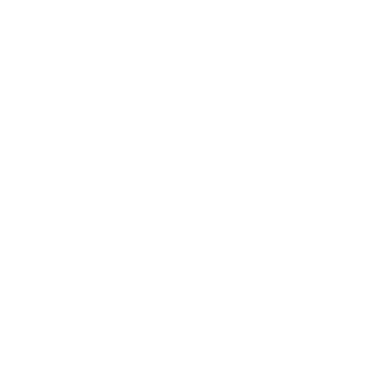

In [8]:
data_shape = (data_dim,)
latent_shape = (latent_dim,)
dt0 = 0.01
sample_size = 1

key, sample_key = jr.split(key)
sample_keys = jr.split(sample_key, sample_size ** 2)
sample_fn = partial(
    single_sample_fn, 
    score_network, 
    encoder, 
    int_beta, 
    data_shape, 
    latent_shape, 
    dt0, 
    t1
)
sample = jax.vmap(sample_fn)(sample_keys)

sample = einops.rearrange(
    sample, 
    "(n1 n2) (h w) -> (n1 h) (n2 w)", 
    n1=sample_size, 
    n2=sample_size, 
    h=8, 
    w=8
)

plt.figure()
plt.imshow(sample, cmap="gray_r")
plt.axis("off")
plt.show()

In [9]:
mu, sigma = jax.vmap(encoder.encode, in_axes=(0, None))(X, 0.)
Z = mu + jr.normal(key, (len(X),)) * sigma

plt.hist(Z.flatten(), bins=64, density=True)
plt.show()

ValueError: Incompatible shapes for broadcasting: shapes=[(1797,), (1797, 8)]